In [1]:
#| default_exp rally

# Rally

> Easily analyze a pickleball rally

In [2]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#| export
from pklshop.data import *
from pklshop.stats import *
from pklshop.name import *
from pklshop.game import *
from pklshop.match import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#| export
#! Need to think about how to store these tables so that functions can use them
#! but don't want to have to pass specific tables every time
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 
shots = get_tab_as_df("shot")
shot_type_ref = get_tab_as_df("shot_type_ref")

In [22]:
#|export 

#Turn this into dict?
def shot_color(shot_type: str) -> str:
    if shot_type == "SE":
        return "green"
    elif shot_type == "D":
        return "blue"
    elif shot_type == "tsDrp":
        return "purple"
    elif shot_type == "tsDrv":
        return "red"
    else:
        return "black"

def shot_size(shot_num: int) -> int:
    if len(str(shot_num)) == 1:
        size=100
    else:
        size=200
    return size

def plot_court():

        # Draw the court and non-volley zone
        plt.fill_between([0, 20], [-22, -22], [22, 22], color='darkblue', alpha=0.5)
        plt.fill_between([0, 20], [-7, -7], [7, 7], color='green', alpha=0.5)

        #Draw lines
        plt.plot([10, 10], [7.1, 22], color='white', linestyle='-', linewidth=1.5)
        plt.plot([10, 10], [-7.1, -22], color='white', linestyle='-', linewidth=1.5)
        plt.plot([0, 0], [-22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([20, 20], [-22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [-22, -22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [7, 7], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [-7, -7], color='white', linestyle='-', linewidth=2)

        #Draw net
        plt.plot([-0.5, 20.5], [0, 0], color='black', linestyle='-', linewidth=2)

        plt.axis('off')

def ball_travel_distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [32]:
#| export
class Rally:
    def __init__(self, rally_id: str):
        self.rally_id= rally_id
        self.rally = rally[rally.rally_id == rally_id] # todo catch invalid rally number
        self.shots = shots[shots.rally_id == rally_id].sort_values("shot_nbr")
        self.rally_len = len(self.shots)
        self.shot_types = self.shots.shot_type_orig
        self.xcoords = [float(x_loc) for x_loc in self.shots.loc_x]
        self.ycoords = [float(y_loc) for y_loc in self.shots.loc_y]
        self.ycoords_flipped = self.flip_y()

        self.ball_travel_dists = self.get_ball_travel_dists()
        self.ball_travel_times = self.get_ball_travel_times()
        self.ball_speeds = [self.ball_travel_dists[i]/self.ball_travel_times[i] for i in range(len(self.ball_travel_dists))]

        
        self.serving_team_id = self.rally.srv_team_id.values[0]
        self.returning_team_id = self.rally.rtrn_team_id.values[0]
    
    def __str__(self):
        return f"Rally {self.rally_id}"
    __repr__ = __str__

    def flip_y(self):
        y_arr = []
        for i, y in enumerate(self.ycoords):
            #Reverse the y location of every other shot
            if i % 2 == 0:
                y_arr.append(y)
            else:
                y_arr.append(-y) 
        return y_arr
    
    def get_ball_travel_dists(self):
        dists = []
        for i in range(len(self.xcoords)-1):
            dists.append(ball_travel_distance(self.xcoords[i], self.ycoords_flipped[i], self.xcoords[i+1], self.ycoords_flipped[i+1]))
        return dists
    
    def get_ball_travel_times(self):
        times = []
        for i in range(len(self.xcoords)-1):
            times.append(float(self.shots.btt_after.iloc[i]))
        return times

    def plot_rally(self):

        n = range(1, len(self.xcoords) + 1)
        fig = plt.figure(figsize=(5,5.5))

        plot_court()

        for xi, yi, shoti, shot_num in zip(self.xcoords, self.ycoords_flipped, self.shot_types, n):
            
            color, size = shot_color(shoti), shot_size(shot_num)

            plt.scatter(xi, yi, marker=f'${shot_num}$', color=color, s=size, zorder=2)
        
        plt.text(10, 26, f"{get_team_name(self.serving_team_id)}", fontsize=20, color='black', zorder=3, horizontalalignment='center')
        plt.text(10, -28, f"{get_team_name(self.returning_team_id)}", fontsize=20, color='black', zorder=3, horizontalalignment='center')

        plt.xlim(-2.5, 22.5)
        plt.ylim(-24.5, 24.5)

        ax = plt.gca()
        ax.add_artist(ax.patch)
        ax.patch.set_zorder(-1)
        
        ax.set_facecolor('lightblue')
        fig.set_facecolor('lightblue')

        # plt.savefig("../figures/rally.png", facecolor=fig.get_facecolor())

        plt.show()

In [33]:
r = Rally("R1009")

In [34]:
r.shots.head()

,shot_id,rally_id,shot_nbr,shot_type_orig,shot_type,player_id,entry_ts,btt_before,btt_after,loc_x,loc_y,next_loc_x,next_loc_y,shot_type_model_id,whtb_model_id,maint_dtm,maint_app,create_dtm,create_app
11372,S10650,R1009,1,SE,None,P6,2022-08-16 17:01:58.200505,None,0.4223,7.34,21.54,2.42,19.82,None,None,2022-08-16 21:22:01.398996+00:00,postgres,2022-08-16 21:22:01.398996+00:00,postgres
11373,S10651,R1009,2,R,None,P13,2022-08-16 17:02:00.663168,0.4223,0.4333,2.42,19.82,5.40,21.54,None,None,2022-08-16 21:22:01.399987+00:00,postgres,2022-08-16 21:22:01.399987+00:00,postgres
11374,S10652,R1009,3,tsDrp,None,P24,2022-08-16 17:02:03.172064,0.4333,0.6495,5.40,21.54,10.21,6.30,None,None,2022-08-16 21:22:01.400981+00:00,postgres,2022-08-16 21:22:01.400981+00:00,postgres
10647,S10653,R1009,4,D,None,P13,2022-08-16 17:02:06.591431,0.6495,0.1316,10.21,6.30,2.19,7.45,None,WWTB_ClassifierDRF_1_AutoML_1_20221108_171453.zip,2022-11-08 23:25:58.791397+00:00,postgres,2022-08-16 21:22:01.401988+00:00,postgres
10648,S10654,R1009,5,D,None,P24,2022-08-16 17:02:07.830403,0.1316,0.5544,2.19,7.45,10.55,6.42,None,WWTB_ClassifierDRF_1_AutoML_1_20221108_171453.zip,2022-11-08 23:25:58.791397+00:00,postgres,2022-08-16 21:22:01.402983+00:00,postgres


In [35]:
travel_dists = []
for i in range(len(r.xcoords)-1):
    x1, y1 = r.xcoords[i], r.ycoords[i]
    x2, y2 = r.xcoords[i+1], r.ycoords[i+1]
    travel_dists.append(ball_travel_distance(x1, y1, x2, y2))

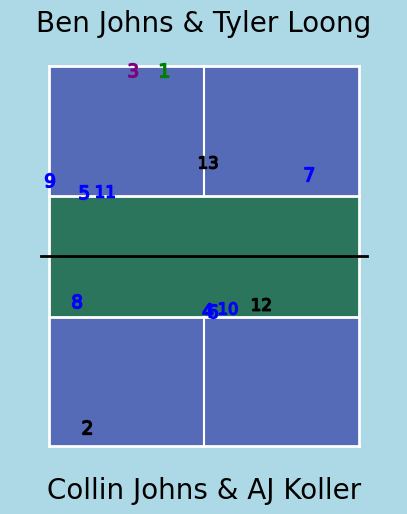

In [36]:
r.plot_rally()

In [11]:
shots.columns

Index(['shot_id', 'rally_id', 'shot_nbr', 'shot_type_orig', 'shot_type',
       'player_id', 'entry_ts', 'btt_before', 'btt_after', 'loc_x', 'loc_y',
       'next_loc_x', 'next_loc_y', 'shot_type_model_id', 'whtb_model_id',
       'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [12]:
r.rally.columns

Index(['rally_id', 'match_id', 'game_id', 'rally_nbr', 'srv_team_id',
       'srv_player_id', 'rtrn_team_id', 'rtrn_player_id', 'ts_player_id',
       'ts_type', 'w_team_id', 'to_ind', 'to_team_id', 'rally_len',
       'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind',
       'rtrn_team_flipped_ind', 'ending_type', 'ending_player_id', 'lob_cnt',
       'dink_cnt', 'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [13]:
#| hide
import nbdev; nbdev.nbdev_export()